In [668]:
import os
import pandas as pd
import numpy as np
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import scipy.stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pycaret.regression import setup, compare_models
from pandas_profiling import ProfileReport
from sklearn.metrics import f1_score
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestClassifier
from pdpbox import pdp, get_dataset, info_plots
from sklearn.model_selection import train_test_split
import shutil
%matplotlib inline

In [669]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [670]:
sns.set_style('darkgrid')

In [671]:
# if don't have data for the day's slate size, comment out any lines using todays_slate_size and everything will run using all slate sizes
todays_slate_size = 4

# Training Data Import

**Part A) Importing past player projection data**

In [672]:
previous_year_data_path = 'C:/Users/mattd/OneDrive/Documents/ff/NBA/2022/contests/unprocessed'
dir_list = os.listdir(previous_year_data_path)

print(dir_list)

[]


In [673]:
projection_files = []
 
# dirs=directories
for (root, dirs, file) in os.walk(previous_year_data_path):
    for f in file:
        if 'DailyRoto' in f:
            projection_files.append(f)
            
print(projection_files)

[]


In [674]:
# sorting the files using regular expression -> reference from here: https://stackoverflow.com/questions/5967500/how-to-correctly-sort-a-string-with-a-number-inside

def atof(text):
    try:
        retval = float(text)
    except ValueError:
        retval = text
    return retval

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    float regex comes from https://stackoverflow.com/a/12643073/190597
    '''
    return [ atof(c) for c in re.split(r'[+-]?([0-9]+(?:[.][0-9]*)?|[.][0-9]+)', text) ]

projection_files.sort(key=natural_keys)
print(projection_files)

[]


In [675]:
dir_list.sort(key=natural_keys)
dir_list

[]

In [676]:
projection_files

[]

In [677]:
dir_file_zip = list(zip(dir_list, projection_files))
dir_file_zip

[]

**DailyRoto import**

In [678]:
all_dr_data = pd.DataFrame()

for dir_file in dir_file_zip:
    full_path = f'{previous_year_data_path}/{dir_file[0]}/{dir_file[1]}'
    new_file = pd.read_csv(full_path)
    new_file['slate'] = pd.to_datetime(dir_file[0])
    new_file['slate_size'] = int(new_file['Team'].nunique()/2)
    all_dr_data = pd.concat([all_dr_data, new_file])

all_dr_data.reset_index(drop=True, inplace=True)
    
all_dr_data.head()

""


In [679]:
# # original file creation
# all_dr_data.to_csv('all_dr_data.csv', index=False)

# # appending to the file
all_dr_data.to_csv('all_dr_data.csv', mode='a', index=False, header=False)

In [680]:
all_dr_data = pd.read_csv('all_dr_data.csv', parse_dates=['slate'])
all_dr_data.head()

,Team,Opp,Player,Slate PlayerID,Unnamed: 4,Minutes,Usage Rate,Rebound Rate,AssistRate,Unnamed: 9,Pos,Public %,Optimal%,Leverage,Salary,Points,Value,slate,slate_size
0,LAL,GS,LeBron James,24617409,NaN,35.4,29.44,11.61,30.47,NaN,SF/PF,61.9,49.4,-12.5,9200,50.10,6.30,2022-10-18,2
1,PHI,BOS,Joel Embiid,24617404,NaN,34.4,33.86,18.14,17.24,NaN,C,57.7,47.4,-10.3,9900,49.97,3.37,2022-10-18,2
2,BOS,PHI,Jayson Tatum,24617413,NaN,36.0,29.11,12.86,19.15,NaN,SF/PF,49.2,45.3,-3.9,9000,45.56,2.56,2022-10-18,2
3,LAL,GS,Anthony Davis,24617421,NaN,34.2,25.26,15.31,13.36,NaN,PF/C,37.2,41.4,4.2,8500,43.81,2.81,2022-10-18,2
4,PHI,BOS,James Harden,24617417,NaN,36.0,24.93,10.03,40.24,NaN,PG/SG,33.3,40.7,7.4,8900,42.93,0.33,2022-10-18,2


**Part B) Importing the contest data**

In [681]:
dir_list

[]

In [682]:
payout_files = []

for week_num in dir_list:
    full_path = f'{previous_year_data_path}/{week_num}'
    payout_dir_list = os.listdir(full_path)
    payout_files.append((week_num, payout_dir_list[0], float(payout_dir_list[0].split()[0])))

payout_files

[]

In [683]:
def remove_string_vals(string):
    num_string = int(''.join([n for n in string if n.isdigit()]))
    return num_string

In [684]:
# https://stackoverflow.com/questions/6713310/regex-specify-space-or-start-of-string-and-space-or-end-of-string
# https://stackoverflow.com/questions/525635/regular-expression-match-start-or-whitespace
# first names like OG will throw errors due to the G

def get_names(text):
#     names = [i.strip() for i in re.split('PG |SG |SF |PF |C |G |F |UTIL ', text) if i] #changing the order of splits does not change anything
    names = [i.strip() for i in re.split(r'(\b)PG |(\b)SG |(\b)SF |(\b)PF |(\b)C |(\b)G |(\b)F |(\b)UTIL ', text) if i] #changing the order of splits does not change anything
    return names

In [685]:
def get_pos_order(text):
    pos_order = [i for i in text.split(' ') if i in ['PG', 'SG', 'SF', 'PF', 'C', 'G', 'F', 'UTIL']]
    return pos_order

In [686]:
error_string = 'PG Bradley Beal C Kristaps Porzingis F Aaron Gordon SF OG Anunoby PF Jabari Smith II SG Ayo Dosunmu UTIL Marcus Smart G R.J. Hampton'
print(get_names(error_string))

['Bradley Beal', 'Kristaps Porzingis', 'Aaron Gordon', 'OG Anunoby', 'Jabari Smith II', 'Ayo Dosunmu', 'Marcus Smart', 'R.J. Hampton']


In [687]:
def process_contest_standings(dir_path, week_num, contest_name, buyin_amount):
    """
    After a contest is completed, there is a csv file that shows the final standings of the contest and there is a text
    file that shows the payouts of the contest. This function imports both files, then calculates the ROI of every player
    within the contest.
    """
    
    # import of contest standings
    standings_dtypes = {
#                         'Rank': int,
                        'EntryId': str,
                        'EntryName': str,
#                         'TimeRemaining': int,
                        'Points': float,
                        'Lineup': str,
                        'Player': str,
                        'Roster Position': str,
                        '%Drafted': str,
                        'FPTS': float 
}
    final_standings = pd.read_csv(f'{dir_path}/{week_num}/{contest_name}', dtype=standings_dtypes, low_memory=False)
    
    # setting the rank equal to the order to deal with tie-breakers
    final_standings['Rank'] = final_standings.index + 1
    
    # import of contest payouts. data is imported all in one unformatted column. creating a new dataframe below which fixes this.
    payouts = pd.read_csv(f'{dir_path}/{week_num}/payouts.txt', sep="\n", header=None, names=['unformatted'], dtype=str, low_memory=False)
    payouts_df = pd.DataFrame({'place':payouts['unformatted'].iloc[::2].values, 'payout':payouts['unformatted'].iloc[1::2].values})
    payouts_df['place_lookup'] = payouts_df['place'].str.split(' - ')
    
    # setting up the payouts so the payout amounts can be mapped to the place in the contest
    lookup_place_list = []
    for row in payouts_df['place_lookup']:
        lookup_place = remove_string_vals(row[0])
        lookup_place_list.append(lookup_place)
    payouts_df['place_lookup'] = lookup_place_list
    missed_payout_place = remove_string_vals(payouts_df.iloc[-1, 0].split(' - ')[-1]) + 1
    payouts_df.loc[len(payouts_df.index)] = [f'{missed_payout_place}+', 0, missed_payout_place]
    
    # looking at only the standings
    player_standings = final_standings.loc[:, :"Lineup"]
    player_standings = player_standings[~player_standings['Lineup'].isna()]
    
    # splitting up the lineup column into individual columns separated by position
    pos_order = player_standings['Lineup'].apply(get_pos_order).tolist()
    name_order = player_standings['Lineup'].apply(get_names).tolist()
    
    sorted_pos_and_names = []
    for i in range(len(pos_order)):
        zipped = list(zip(pos_order[i], name_order[i]))
        sorted_zipped = sorted(zipped, key=lambda x: x[0])
        sorted_pos_and_names.append(sorted_zipped)
        
    all_lineups = []
    for l in sorted_pos_and_names:
        lineup_list = []
        for tup in l:
            lineup_list.append((tup[-1]))
        all_lineups.append(lineup_list)
        
    player_standings = pd.concat([player_standings, pd.DataFrame(all_lineups, columns=['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8'])], axis = 1)
    
    # looking at only the ownership of each player
    ownership_info = final_standings.loc[:, "Player":"FPTS"][final_standings.loc[:, "Player"].notnull()]
    ownership_info['Player'] = ownership_info['Player'].str.strip()
    
    # merging the payouts to the player standings and converting dollar string to floats
    standings_w_payouts = pd.merge_asof(player_standings, payouts_df, left_on='Rank', right_on='place_lookup').drop(columns=['place', 'place_lookup'])
    standings_w_payouts['payout'] = standings_w_payouts['payout'].replace('[\$,]', '', regex=True).astype(float)
    standings_w_payouts['slate_info'] = week_num
    standings_w_payouts['buyin'] = buyin_amount
    standings_w_payouts['ROI'] = ((standings_w_payouts['payout'] - standings_w_payouts['buyin']) / standings_w_payouts['buyin'])*100
    
    # calculate the linearized payout:
    total_payouts = standings_w_payouts['payout'].sum()
    made_payout_df = standings_w_payouts[standings_w_payouts['payout'] > 0].loc[:, ['Rank', 'payout']]
#     made_payout_df = standings_w_payouts.loc[:, ['Rank', 'payout']]
    a, b = np.polyfit(made_payout_df['Rank'], made_payout_df['payout'], 1) #find line of best fit for linearized payout. b is the x intercept, a is the slope
    x_intercept = round((-b)/a)
    base_payout = total_payouts / x_intercept
    new_payout_array = np.empty((x_intercept)) #create an empty array the length of the x_intercept
    new_payout_array[:] = np.NaN
    new_payout_array[0] = base_payout*2
    new_payout_array[-1] = 0
    linearized_payouts = pd.Series(new_payout_array)
    made_payout_df['payout_linearized'] = linearized_payouts.interpolate()
    standings_w_payouts = pd.merge_asof(standings_w_payouts, made_payout_df[['Rank', 'payout_linearized']], left_on='Rank', right_on='Rank')
    standings_w_payouts['payout_linearized'].fillna(0, inplace=True)
    standings_w_payouts['linear_ROI'] = ((standings_w_payouts['payout_linearized'] - standings_w_payouts['buyin']) / standings_w_payouts['buyin'])*100

    # adding in the contest info to the dataframe
    ownership_info['slate_info'] = week_num
    ownership_info['buyin'] = buyin_amount
    ownership_info['%Drafted'] = pd.to_numeric(ownership_info['%Drafted'].str.strip('%'))
    
    return standings_w_payouts, ownership_info

In [688]:
# only need to run once. both dataframes were saved locally and loaded back in

all_standings_w_payouts = pd.DataFrame()
all_ownership_info = pd.DataFrame()
start_time = time.time()
# main()

for files_to_process in payout_files:
    week_num = files_to_process[0]
    contest_name = files_to_process[1]
    buyin_amount = files_to_process[2]
    standings_w_payouts_df, ownership_info_df = process_contest_standings(previous_year_data_path, week_num, contest_name, buyin_amount)
    all_standings_w_payouts = all_standings_w_payouts.append(standings_w_payouts_df, ignore_index=True)
    all_ownership_info = all_ownership_info.append(ownership_info_df, ignore_index=True)
    print(week_num)
    print("--- %s seconds ---" % (time.time() - start_time))

In [689]:
# original file creation
# all_standings_w_payouts.to_csv('all_standings_w_linear_payouts.csv', index=False)
# all_ownership_info.to_csv('all_ownership_info.csv', index=False)

# # appending to the file
all_standings_w_payouts.to_csv('all_standings_w_linear_payouts.csv', mode='a', index=False, header=False)
all_ownership_info.to_csv('all_ownership_info.csv', mode='a', index=False, header=False)

In [690]:
all_standings_w_payouts = pd.read_csv('all_standings_w_linear_payouts.csv', parse_dates=['slate_info'])
all_ownership_info = pd.read_csv('all_ownership_info.csv', parse_dates=['slate_info'])

In [691]:
all_standings_w_payouts.head()

,Rank,EntryId,EntryName,TimeRemaining,Points,Lineup,P1,P2,P3,P4,P5,P6,P7,P8,payout,slate_info,buyin,ROI,payout_linearized,linear_ROI
0,1,3434142504,jugo35 (20/20),0,308.00,PF LeBron James SF Jayson Tatum SG Jaylen Brow...,JaMychal Green,Andrew Wiggins,Tyrese Maxey,LeBron James,Malcolm Brogdon,Jayson Tatum,Jaylen Brown,Kendrick Nunn,5000.0,2022-10-18,3.0,166566.666667,23.337223,677.907429
1,2,3433884104,sasmallen (2/3),0,300.25,F LeBron James PF Jayson Tatum PG James Harden...,P.J. Tucker,LeBron James,Tyrese Maxey,Jayson Tatum,James Harden,Andrew Wiggins,Kendrick Nunn,Lonnie Walker IV,2500.0,2022-10-18,3.0,83233.333333,23.331775,677.725845
2,3,3434553539,BRORANNOSAURUS_FLEX (4/20),0,299.25,UTIL Stephen Curry F LeBron James SF Jayson Ta...,JaMychal Green,LeBron James,Kendrick Nunn,Al Horford,Tyrese Maxey,Jayson Tatum,Marcus Smart,Stephen Curry,1500.0,2022-10-18,3.0,49900.000000,23.326328,677.544260
3,4,3433956127,dwilliamsmma (10/20),0,298.75,UTIL Stephen Curry PF LeBron James SF Jayson T...,Al Horford,Lonnie Walker IV,Kendrick Nunn,LeBron James,Tyrese Maxey,Jayson Tatum,Marcus Smart,Stephen Curry,1000.0,2022-10-18,3.0,33233.333333,23.320880,677.362676
4,5,3434496587,shaung24 (8/8),0,298.75,UTIL Stephen Curry F LeBron James PF Jayson Ta...,Al Horford,LeBron James,Tyrese Maxey,Jayson Tatum,Marcus Smart,Lonnie Walker IV,Kendrick Nunn,Stephen Curry,750.0,2022-10-18,3.0,24900.000000,23.315433,677.181092


In [692]:
all_standings_w_payouts[all_standings_w_payouts['Rank'] == 1]

,Rank,EntryId,EntryName,TimeRemaining,Points,Lineup,P1,P2,P3,P4,P5,P6,P7,P8,payout,slate_info,buyin,ROI,payout_linearized,linear_ROI
0,1,3434142504,jugo35 (20/20),0,308.00,PF LeBron James SF Jayson Tatum SG Jaylen Brow...,JaMychal Green,Andrew Wiggins,Tyrese Maxey,LeBron James,Malcolm Brogdon,Jayson Tatum,Jaylen Brown,Kendrick Nunn,5000.0,2022-10-18,3.00,166566.666667,23.337223,677.907429
19721,1,3435880240,bobpm121 (1/5),0,342.25,SF DeMar DeRozan G De'Aaron Fox SG Terry Rozie...,Santi Aldama,John Collins,De'Aaron Fox,Keldon Johnson,Tre Jones,DeMar DeRozan,Terry Rozier,Jalen Green,10000.0,2022-10-19,4.00,249900.000000,30.402838,660.070940
55360,1,3437823271,gingerhammers (2/10),0,304.25,PF Giannis Antetokounmpo SF LeBron James SG Ja...,Ivica Zubac,Lonnie Walker IV,Patrick Beverley,Giannis Antetokounmpo,Jevon Carter,LeBron James,James Harden,Marcus Morris Sr.,6000.0,2022-10-20,4.00,149900.000000,31.274433,681.860829
73113,1,3441119774,FantasyKiller662 (2/5),0,378.50,UTIL Pascal Siakam PG Fred VanVleet C Jonas Va...,Jonas Valanciunas,Santi Aldama,Bennedict Mathurin,John Collins,Fred VanVleet,Michael Porter Jr.,Devin Vassell,Pascal Siakam,2000.0,2022-10-21,1.00,199900.000000,7.134576,613.457594
120562,1,3442786079,ocdobv (4/20),0,343.75,UTIL Nikola Jokic PG Luka Doncic G Caris LeVer...,Isaiah Jackson,Kevin Love,Caris LeVert,Cedi Osman,Luka Doncic,Saddiq Bey,Derrick White,Nikola Jokic,7500.0,2022-10-22,4.00,187400.000000,30.804775,670.119369
144312,1,3448955569,TNeidert (11/20),0,325.75,PG Donovan Mitchell UTIL Domantas Sabonis C Ja...,Jarrett Allen,Luguentz Dort,Jordan Poole,Kelly Olynyk,Donovan Mitchell,Lauri Markkanen,Jaylen Nowell,Domantas Sabonis,200.0,2022-10-23,1.00,19900.000000,7.518797,651.879699
146685,1,3450135827,ChrisC82 (2/20),0,357.50,PG James Harden G Desmond Bane SG Jalen Green ...,Jarred Vanderbilt,Jalen Smith,Desmond Bane,Jabari Smith Jr.,James Harden,Devin Vassell,Jalen Green,Jakob Poeltl,500.0,2022-10-24,0.25,199900.000000,1.873185,649.274141
194134,1,3452221604,mhaag11223212 (16/20),0,339.25,PG Luka Doncic UTIL Devin Booker G Shai Gilgeo...,Ivica Zubac,Aaron Wiggins,Shai Gilgeous-Alexander,Nicolas Batum,Luka Doncic,Deni Avdija,Will Barton,Devin Booker,10000.0,2022-10-25,4.00,249900.000000,30.402838,660.070940
229771,1,3453212949,laser1000000 (2/2),0,363.50,UTIL Giannis Antetokounmpo PG Jalen Brunson PF...,Mitchell Robinson,Kelly Oubre Jr.,Tyrese Maxey,Lauri Markkanen,Jalen Brunson,Josh Richardson,Bruce Brown,Giannis Antetokounmpo,10000.0,2022-10-26,4.00,249900.000000,30.402838,660.070940
265421,1,3455840457,coltz88 (3/6),0,327.00,G Luka Doncic PG Kyrie Irving C Ivica Zubac SF...,Ivica Zubac,JaMychal Green,Luka Doncic,Max Strus,Kyrie Irving,Luguentz Dort,Aaron Wiggins,Darius Bazley,7500.0,2022-10-27,4.00,187400.000000,30.804775,670.119369


In [693]:
all_ownership_info

,Player,Roster Position,%Drafted,FPTS,slate_info,buyin
0,Al Horford,F,65.17,14.75,2022-10-18,3.0
1,Joel Embiid,C,64.01,53.25,2022-10-18,3.0
2,Tyrese Maxey,UTIL,58.63,29.75,2022-10-18,3.0
3,LeBron James,PF,55.22,61.00,2022-10-18,3.0
4,Anthony Davis,UTIL,51.57,43.00,2022-10-18,3.0
...,...,...,...,...,...,...
2171,Admiral Schofield,PF,0.00,8.00,2022-10-28,1.0
2172,Taj Gibson,UTIL,0.00,0.00,2022-10-28,1.0
2173,Jonathan Isaac,PF,0.00,0.00,2022-10-28,1.0
2174,Simone Fontecchio,UTIL,0.00,0.00,2022-10-28,1.0


# Merging Actual Ownership Info

In [694]:
# merge_cols = all_standings_w_payouts.loc[:, 'P1':'P8'].columns
# new_df = all_standings_w_payouts.copy()
# ownership_trim = all_ownership_info[['Player', '%Drafted', 'slate_info']]

# for roster_spot in merge_cols:
#     full_df = pd.merge(new_df, ownership_trim, how='left', left_on=[roster_spot,'slate_info'], right_on = ['Player','slate_info']).drop(columns = ['Player'])
#     full_df = full_df.rename(columns={'%Drafted': f'{roster_spot}%Own'})
#     new_df = full_df.copy()

# full_df.head()

In [695]:
# full_df.isna().sum()

In [696]:
full_df = all_standings_w_payouts.copy()

# Merging Salaries, Projections, and Leverage

In [697]:
all_dr_data.head()

,Team,Opp,Player,Slate PlayerID,Unnamed: 4,Minutes,Usage Rate,Rebound Rate,AssistRate,Unnamed: 9,Pos,Public %,Optimal%,Leverage,Salary,Points,Value,slate,slate_size
0,LAL,GS,LeBron James,24617409,NaN,35.4,29.44,11.61,30.47,NaN,SF/PF,61.9,49.4,-12.5,9200,50.10,6.30,2022-10-18,2
1,PHI,BOS,Joel Embiid,24617404,NaN,34.4,33.86,18.14,17.24,NaN,C,57.7,47.4,-10.3,9900,49.97,3.37,2022-10-18,2
2,BOS,PHI,Jayson Tatum,24617413,NaN,36.0,29.11,12.86,19.15,NaN,SF/PF,49.2,45.3,-3.9,9000,45.56,2.56,2022-10-18,2
3,LAL,GS,Anthony Davis,24617421,NaN,34.2,25.26,15.31,13.36,NaN,PF/C,37.2,41.4,4.2,8500,43.81,2.81,2022-10-18,2
4,PHI,BOS,James Harden,24617417,NaN,36.0,24.93,10.03,40.24,NaN,PG/SG,33.3,40.7,7.4,8900,42.93,0.33,2022-10-18,2


In [698]:
all_proj_clean = all_dr_data[['Player', 'Salary', 'Points', 'Public %', 'Leverage', 'slate', 'slate_size']]
all_proj_clean

,Player,Salary,Points,Public %,Leverage,slate,slate_size
0,LeBron James,9200,50.10,61.9,-12.5,2022-10-18,2
1,Joel Embiid,9900,49.97,57.7,-10.3,2022-10-18,2
2,Jayson Tatum,9000,45.56,49.2,-3.9,2022-10-18,2
3,Anthony Davis,8500,43.81,37.2,4.2,2022-10-18,2
4,James Harden,8900,42.93,33.3,7.4,2022-10-18,2
...,...,...,...,...,...,...,...
2543,AJ Green,3000,0.00,0.0,0.0,2022-10-28,11
2544,Buddy Boeheim,3000,0.00,0.0,0.0,2022-10-28,11
2545,Darius Days,3000,0.00,0.0,0.0,2022-10-28,11
2546,Jack White,3000,0.00,0.0,0.0,2022-10-28,11


In [699]:
# fixing DR and DK name mismatches
name_mismatch_list = pd.read_csv('name_fixes.csv')
find_list = name_mismatch_list['DR'].tolist()
replace_list = name_mismatch_list['DK'].tolist()

for i in range(len(find_list)):
    find_name = find_list[i]
    replace_name = replace_list[i]
    all_proj_clean['Player'].replace(find_name, replace_name, inplace=True)

In [700]:
all_ownership_info

,Player,Roster Position,%Drafted,FPTS,slate_info,buyin
0,Al Horford,F,65.17,14.75,2022-10-18,3.0
1,Joel Embiid,C,64.01,53.25,2022-10-18,3.0
2,Tyrese Maxey,UTIL,58.63,29.75,2022-10-18,3.0
3,LeBron James,PF,55.22,61.00,2022-10-18,3.0
4,Anthony Davis,UTIL,51.57,43.00,2022-10-18,3.0
...,...,...,...,...,...,...
2171,Admiral Schofield,PF,0.00,8.00,2022-10-28,1.0
2172,Taj Gibson,UTIL,0.00,0.00,2022-10-28,1.0
2173,Jonathan Isaac,PF,0.00,0.00,2022-10-28,1.0
2174,Simone Fontecchio,UTIL,0.00,0.00,2022-10-28,1.0


In [701]:
all_proj_clean = pd.merge(all_proj_clean, all_ownership_info[['Player', 'slate_info']], how='left', left_on=['Player','slate'], right_on = ['Player','slate_info']).drop(columns=['slate_info'])
all_proj_clean

,Player,Salary,Points,Public %,Leverage,slate,slate_size
0,LeBron James,9200,50.10,61.9,-12.5,2022-10-18,2
1,Joel Embiid,9900,49.97,57.7,-10.3,2022-10-18,2
2,Jayson Tatum,9000,45.56,49.2,-3.9,2022-10-18,2
3,Anthony Davis,8500,43.81,37.2,4.2,2022-10-18,2
4,James Harden,8900,42.93,33.3,7.4,2022-10-18,2
...,...,...,...,...,...,...,...
2543,AJ Green,3000,0.00,0.0,0.0,2022-10-28,11
2544,Buddy Boeheim,3000,0.00,0.0,0.0,2022-10-28,11
2545,Darius Days,3000,0.00,0.0,0.0,2022-10-28,11
2546,Jack White,3000,0.00,0.0,0.0,2022-10-28,11


In [702]:
all_proj_clean = all_proj_clean[['Player', 'Salary', 'Points', 'slate', 'Public %', 'Leverage']]
all_proj_clean.rename(columns={"Points": "DRProj"}, inplace=True)
all_proj_clean.head(3)

,Player,Salary,DRProj,slate,Public %,Leverage
0,LeBron James,9200,50.10,2022-10-18,61.9,-12.5
1,Joel Embiid,9900,49.97,2022-10-18,57.7,-10.3
2,Jayson Tatum,9000,45.56,2022-10-18,49.2,-3.9


In [703]:
merge_cols = full_df.loc[:, 'P1':'P8'].columns
new_df = full_df.copy()

for roster_spot in merge_cols:
    full_df = pd.merge(new_df, all_proj_clean, how='left', left_on=[roster_spot,'slate_info'], right_on = ['Player','slate']).drop(columns = ['Player', 'slate'])
    full_df = full_df.rename(columns={'Salary': f'{roster_spot}_Sal', 'DRProj': f'{roster_spot}_DR', 'Public %': f'{roster_spot}%Own', 'Leverage': f'{roster_spot}_Leverage'})
    new_df = full_df.copy()

full_df.head()

,Rank,EntryId,EntryName,TimeRemaining,Points,Lineup,P1,P2,P3,P4,P5,P6,P7,P8,payout,slate_info,buyin,ROI,payout_linearized,linear_ROI,P1_Sal,P1_DR,P1%Own,P1_Leverage,P2_Sal,P2_DR,P2%Own,P2_Leverage,P3_Sal,P3_DR,P3%Own,P3_Leverage,P4_Sal,P4_DR,P4%Own,P4_Leverage,P5_Sal,P5_DR,P5%Own,P5_Leverage,P6_Sal,P6_DR,P6%Own,P6_Leverage,P7_Sal,P7_DR,P7%Own,P7_Leverage,P8_Sal,P8_DR,P8%Own,P8_Leverage
0,1,3434142504,jugo35 (20/20),0,308.00,PF LeBron James SF Jayson Tatum SG Jaylen Brow...,JaMychal Green,Andrew Wiggins,Tyrese Maxey,LeBron James,Malcolm Brogdon,Jayson Tatum,Jaylen Brown,Kendrick Nunn,5000.0,2022-10-18,3.0,166566.666667,23.337223,677.907429,3800.0,9.23,4.9,2.8,7000.0,27.22,8.2,4.8,5000.0,27.59,38.1,-10.0,9200.0,50.10,61.9,-12.5,4900.0,28.58,48.3,-10.4,9000.0,45.56,49.2,-3.9,8000.0,38.47,28.8,6.5,3000.0,18.70,29.2,-4.1
1,2,3433884104,sasmallen (2/3),0,300.25,F LeBron James PF Jayson Tatum PG James Harden...,P.J. Tucker,LeBron James,Tyrese Maxey,Jayson Tatum,James Harden,Andrew Wiggins,Kendrick Nunn,Lonnie Walker IV,2500.0,2022-10-18,3.0,83233.333333,23.331775,677.725845,3700.0,17.85,17.6,-3.3,9200.0,50.10,61.9,-12.5,5000.0,27.59,38.1,-10.0,9000.0,45.56,49.2,-3.9,8900.0,42.93,33.3,7.4,7000.0,27.22,8.2,4.8,3000.0,18.70,29.2,-4.1,4200.0,22.13,21.6,-2.9
2,3,3434553539,BRORANNOSAURUS_FLEX (4/20),0,299.25,UTIL Stephen Curry F LeBron James SF Jayson Ta...,JaMychal Green,LeBron James,Kendrick Nunn,Al Horford,Tyrese Maxey,Jayson Tatum,Marcus Smart,Stephen Curry,1500.0,2022-10-18,3.0,49900.000000,23.326328,677.544260,3800.0,9.23,4.9,2.8,9200.0,50.10,61.9,-12.5,3000.0,18.70,29.2,-4.1,4900.0,29.07,52.9,-18.5,5000.0,27.59,38.1,-10.0,9000.0,45.56,49.2,-3.9,5200.0,27.77,33.9,-6.1,9400.0,39.88,20.4,15.5
3,4,3433956127,dwilliamsmma (10/20),0,298.75,UTIL Stephen Curry PF LeBron James SF Jayson T...,Al Horford,Lonnie Walker IV,Kendrick Nunn,LeBron James,Tyrese Maxey,Jayson Tatum,Marcus Smart,Stephen Curry,1000.0,2022-10-18,3.0,33233.333333,23.320880,677.362676,4900.0,29.07,52.9,-18.5,4200.0,22.13,21.6,-2.9,3000.0,18.70,29.2,-4.1,9200.0,50.10,61.9,-12.5,5000.0,27.59,38.1,-10.0,9000.0,45.56,49.2,-3.9,5200.0,27.77,33.9,-6.1,9400.0,39.88,20.4,15.5
4,5,3434496587,shaung24 (8/8),0,298.75,UTIL Stephen Curry F LeBron James PF Jayson Ta...,Al Horford,LeBron James,Tyrese Maxey,Jayson Tatum,Marcus Smart,Lonnie Walker IV,Kendrick Nunn,Stephen Curry,750.0,2022-10-18,3.0,24900.000000,23.315433,677.181092,4900.0,29.07,52.9,-18.5,9200.0,50.10,61.9,-12.5,5000.0,27.59,38.1,-10.0,9000.0,45.56,49.2,-3.9,5200.0,27.77,33.9,-6.1,4200.0,22.13,21.6,-2.9,3000.0,18.70,29.2,-4.1,9400.0,39.88,20.4,15.5


In [704]:
full_df.isna().sum()

Rank                   0
EntryId                0
EntryName              0
TimeRemaining          0
Points                 0
Lineup                 0
P1                     0
P2                     0
P3                     0
P4                     0
P5                     0
P6                     0
P7                     0
P8                     0
payout                 0
slate_info             0
buyin                  0
ROI                    0
payout_linearized      0
linear_ROI             0
P1_Sal               107
P1_DR                107
P1%Own               107
P1_Leverage          107
P2_Sal                91
P2_DR                 91
P2%Own                91
P2_Leverage           91
P3_Sal               315
P3_DR                315
P3%Own               315
P3_Leverage          315
P4_Sal                16
P4_DR                 16
P4%Own                16
P4_Leverage           16
P5_Sal               387
P5_DR                387
P5%Own               387
P5_Leverage          387


In [705]:
# these are lineups playing players without projections

full_df[full_df['P8_Leverage'].isna()]

,Rank,EntryId,EntryName,TimeRemaining,Points,Lineup,P1,P2,P3,P4,P5,P6,P7,P8,payout,slate_info,buyin,ROI,payout_linearized,linear_ROI,P1_Sal,P1_DR,P1%Own,P1_Leverage,P2_Sal,P2_DR,P2%Own,P2_Leverage,P3_Sal,P3_DR,P3%Own,P3_Leverage,P4_Sal,P4_DR,P4%Own,P4_Leverage,P5_Sal,P5_DR,P5%Own,P5_Leverage,P6_Sal,P6_DR,P6%Own,P6_Leverage,P7_Sal,P7_DR,P7%Own,P7_Leverage,P8_Sal,P8_DR,P8%Own,P8_Leverage
4899,4900,3433998096,Msweat1971 (2/2),0,270.00,PG Stephen Curry SF LeBron James PF Jayson Tat...,Draymond Green,P.J. Tucker,Tyrese Maxey,Jayson Tatum,Stephen Curry,LeBron James,Malcolm Brogdon,Charles Bassey,5.0,2022-10-18,3.0,66.666667,0.0,-100.0,5800.0,27.66,19.3,3.5,3700.0,17.85,17.6,-3.3,5000.0,27.59,38.1,-10.0,9000.0,45.56,49.2,-3.9,9400.0,39.88,20.4,15.5,9200.0,50.10,61.9,-12.5,4900.0,28.58,48.3,-10.4,NaN,NaN,NaN,NaN
16023,16024,3434112761,Jwikoff2,0,243.75,C Joel Embiid G Stephen Curry PG James Harden ...,Joel Embiid,Al Horford,Stephen Curry,Grant Williams,James Harden,Andrew Wiggins,Brodric Thomas,Quinndary Weatherspoon,0.0,2022-10-18,3.0,-100.000000,0.0,-100.0,9900.0,49.97,57.7,-10.3,4900.0,29.07,52.9,-18.5,9400.0,39.88,20.4,15.5,3900.0,16.40,11.8,-0.6,8900.0,42.93,33.3,7.4,7000.0,27.22,8.2,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16893,16894,3427830236,Buckeyeohmy,0,240.50,SF LeBron James G Russell Westbrook F Andrew W...,Draymond Green,Andrew Wiggins,Russell Westbrook,Tobias Harris,Jordan Poole,LeBron James,Malcolm Brogdon,Jake Layman,0.0,2022-10-18,3.0,-100.000000,0.0,-100.0,5800.0,27.66,19.3,3.5,7000.0,27.22,8.2,4.8,7400.0,27.22,4.6,8.4,5900.0,27.97,21.0,-1.5,6700.0,29.61,12.7,7.3,9200.0,50.10,61.9,-12.5,4900.0,28.58,48.3,-10.4,NaN,NaN,NaN,NaN
17133,17134,3433855994,placinbets2022,0,239.50,C Joel Embiid SF Jayson Tatum SG Jaylen Brown ...,Joel Embiid,Moses Moody,Malcolm Brogdon,Al Horford,Jordan Poole,Jayson Tatum,Jaylen Brown,Charlie Brown,0.0,2022-10-18,3.0,-100.000000,0.0,-100.0,9900.0,49.97,57.7,-10.3,3000.0,10.96,6.2,0.8,4900.0,28.58,48.3,-10.4,4900.0,29.07,52.9,-18.5,6700.0,29.61,12.7,7.3,9000.0,45.56,49.2,-3.9,8000.0,38.47,28.8,6.5,NaN,NaN,NaN,NaN
17403,17404,3430429395,nittyboss,0,238.25,PG Stephen Curry SF LeBron James SG James Hard...,Al Horford,Anthony Davis,Scotty Pippen Jr.,Patrick Baldwin Jr.,Stephen Curry,LeBron James,James Harden,Quinndary Weatherspoon,0.0,2022-10-18,3.0,-100.000000,0.0,-100.0,4900.0,29.07,52.9,-18.5,8500.0,43.81,37.2,4.2,3000.0,0.00,0.0,0.0,3000.0,0.00,0.0,0.0,9400.0,39.88,20.4,15.5,9200.0,50.10,61.9,-12.5,8900.0,42.93,33.3,7.4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335756,46568,3457392619,spears2013 (2/7),0,179.50,C Nikola Jokic G James Harden SF Gordon Haywar...,Nikola Jokic,Jalen McDaniels,James Harden,Rui Hachimura,Dennis Smith Jr.,Gordon Hayward,James Bouknight,Theo Maledon,0.0,2022-10-28,1.0,-100.000000,0.0,-100.0,11000.0,60.53,23.0,-5.3,4800.0,20.20,1.9,-0.3,9700.0,49.41,18.0,-6.2,4400.0,19.18,1.9,-0.8,6300.0,32.30,7.0,-2.1,6700.0,35.11,8.1,-1.1,3600.0,15.99,1.6,2.5,NaN,NaN,NaN,NaN
336131,46943,3457911142,SeanMizzle (19/20),0,173.00,C Nikola Jokic PG Kevin Porter Jr. PF Jabari S...,Nikola Jokic,Isaiah Livers,Dennis Smith Jr.,Jabari Smith Jr.,Kevin Porter Jr.,Lonnie Walker IV,Gary Trent Jr.,Theo Maledon,0.0,2022-10-28,1.0,-100.000000,0.0,-100.0,11000.0,60.53,23.0,-5.3,3700.0,13.34,1.0,-0.4,6300.0,32.30,7.0,-2.1,6600.0,28.31,3.0,-0.9,7600.0,36.29,6.6,-0.1,5300.0,27.59,3.3,0.4,6000.0,28.25,3.3,0.6,NaN,NaN,NaN,NaN
336425,47237,3458114524,wilkinsa11 (1/3),0,164.25,SG Devin Booker PG Jalen Brunson C Wendell Car...,Wendell Carter Jr.,Jarred Vanderbilt,Terrence Ross,PJ Washington,Jalen Brunson,Franz Wagner,Devin Booker,Theo Maledon,0.0,2022-10-28,1.0,-100.000000,0.0,-100.0,6900.0,36.46,7.8,-0.5,5600.0,26.62,2.8,0.0,5400.0,21.52,1.6,-0.2,5900.0,28.45,4.4,-1.3,7300.0,30.93,3.3,-1.6,6400.0,33.36,10.9,-6.0,9000.0,43.81,7.7,

In [706]:
clean_proj_df = full_df.dropna(subset=['P1_DR', 'P2_DR', 'P3_DR', 'P4_DR', 'P5_DR', 'P6_DR', 'P7_DR', 'P8_DR'])

In [707]:
clean_proj_df.head(3)

,Rank,EntryId,EntryName,TimeRemaining,Points,Lineup,P1,P2,P3,P4,P5,P6,P7,P8,payout,slate_info,buyin,ROI,payout_linearized,linear_ROI,P1_Sal,P1_DR,P1%Own,P1_Leverage,P2_Sal,P2_DR,P2%Own,P2_Leverage,P3_Sal,P3_DR,P3%Own,P3_Leverage,P4_Sal,P4_DR,P4%Own,P4_Leverage,P5_Sal,P5_DR,P5%Own,P5_Leverage,P6_Sal,P6_DR,P6%Own,P6_Leverage,P7_Sal,P7_DR,P7%Own,P7_Leverage,P8_Sal,P8_DR,P8%Own,P8_Leverage
0,1,3434142504,jugo35 (20/20),0,308.00,PF LeBron James SF Jayson Tatum SG Jaylen Brow...,JaMychal Green,Andrew Wiggins,Tyrese Maxey,LeBron James,Malcolm Brogdon,Jayson Tatum,Jaylen Brown,Kendrick Nunn,5000.0,2022-10-18,3.0,166566.666667,23.337223,677.907429,3800.0,9.23,4.9,2.8,7000.0,27.22,8.2,4.8,5000.0,27.59,38.1,-10.0,9200.0,50.10,61.9,-12.5,4900.0,28.58,48.3,-10.4,9000.0,45.56,49.2,-3.9,8000.0,38.47,28.8,6.5,3000.0,18.70,29.2,-4.1
1,2,3433884104,sasmallen (2/3),0,300.25,F LeBron James PF Jayson Tatum PG James Harden...,P.J. Tucker,LeBron James,Tyrese Maxey,Jayson Tatum,James Harden,Andrew Wiggins,Kendrick Nunn,Lonnie Walker IV,2500.0,2022-10-18,3.0,83233.333333,23.331775,677.725845,3700.0,17.85,17.6,-3.3,9200.0,50.10,61.9,-12.5,5000.0,27.59,38.1,-10.0,9000.0,45.56,49.2,-3.9,8900.0,42.93,33.3,7.4,7000.0,27.22,8.2,4.8,3000.0,18.70,29.2,-4.1,4200.0,22.13,21.6,-2.9
2,3,3434553539,BRORANNOSAURUS_FLEX (4/20),0,299.25,UTIL Stephen Curry F LeBron James SF Jayson Ta...,JaMychal Green,LeBron James,Kendrick Nunn,Al Horford,Tyrese Maxey,Jayson Tatum,Marcus Smart,Stephen Curry,1500.0,2022-10-18,3.0,49900.000000,23.326328,677.544260,3800.0,9.23,4.9,2.8,9200.0,50.10,61.9,-12.5,3000.0,18.70,29.2,-4.1,4900.0,29.07,52.9,-18.5,5000.0,27.59,38.1,-10.0,9000.0,45.56,49.2,-3.9,5200.0,27.77,33.9,-6.1,9400.0,39.88,20.4,15.5


In [708]:
clean_proj_df.isna().sum()

Rank                 0
EntryId              0
EntryName            0
TimeRemaining        0
Points               0
Lineup               0
P1                   0
P2                   0
P3                   0
P4                   0
P5                   0
P6                   0
P7                   0
P8                   0
payout               0
slate_info           0
buyin                0
ROI                  0
payout_linearized    0
linear_ROI           0
P1_Sal               0
P1_DR                0
P1%Own               0
P1_Leverage          0
P2_Sal               0
P2_DR                0
P2%Own               0
P2_Leverage          0
P3_Sal               0
P3_DR                0
P3%Own               0
P3_Leverage          0
P4_Sal               0
P4_DR                0
P4%Own               0
P4_Leverage          0
P5_Sal               0
P5_DR                0
P5%Own               0
P5_Leverage          0
P6_Sal               0
P6_DR                0
P6%Own               0
P6_Leverage

# Aggregation and Table Clean-up

In [709]:
clean_proj_df.columns

Index(['Rank', 'EntryId', 'EntryName', 'TimeRemaining', 'Points', 'Lineup',
       'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'payout', 'slate_info',
       'buyin', 'ROI', 'payout_linearized', 'linear_ROI', 'P1_Sal', 'P1_DR',
       'P1%Own', 'P1_Leverage', 'P2_Sal', 'P2_DR', 'P2%Own', 'P2_Leverage',
       'P3_Sal', 'P3_DR', 'P3%Own', 'P3_Leverage', 'P4_Sal', 'P4_DR', 'P4%Own',
       'P4_Leverage', 'P5_Sal', 'P5_DR', 'P5%Own', 'P5_Leverage', 'P6_Sal',
       'P6_DR', 'P6%Own', 'P6_Leverage', 'P7_Sal', 'P7_DR', 'P7%Own',
       'P7_Leverage', 'P8_Sal', 'P8_DR', 'P8%Own', 'P8_Leverage'],
      dtype='object')

In [710]:
clean_proj_df['Total_Salary'] = clean_proj_df[['P1_Sal', 'P2_Sal', 'P3_Sal', 'P4_Sal', 'P5_Sal', 'P6_Sal', 'P7_Sal', 'P8_Sal']].sum(axis=1)
clean_proj_df['Proj_Points'] = clean_proj_df[['P1_DR', 'P2_DR', 'P3_DR', 'P4_DR', 'P5_DR', 'P6_DR', 'P7_DR', 'P8_DR']].sum(axis=1)
clean_proj_df['Total_Own'] = clean_proj_df[['P1%Own', 'P2%Own', 'P3%Own', 'P4%Own', 'P5%Own', 'P6%Own', 'P7%Own', 'P8%Own']].sum(axis=1)
clean_proj_df['Total_Leverage'] = clean_proj_df[['P1_Leverage', 'P2_Leverage', 'P3_Leverage', 'P4_Leverage', 'P5_Leverage', 'P6_Leverage', 'P7_Leverage', 'P8_Leverage']].sum(axis=1)

In [711]:
def made_payout(roi):
    if roi > 0:
        result = 1
    else:
        result = 0
    return result

clean_proj_df['Made_Payout'] = clean_proj_df['ROI'].apply(made_payout)

In [712]:
slate_size_join = all_dr_data[['slate', 'slate_size']].drop_duplicates()
slate_size_join['slate_size'].value_counts().sort_index()

2     2
4     2
5     1
8     2
10    1
11    2
12    1
Name: slate_size, dtype: int64

In [713]:
clean_proj_df = pd.merge(clean_proj_df, slate_size_join, how='left', left_on='slate_info', right_on='slate').drop(columns='slate')
clean_proj_df.head(3)

,Rank,EntryId,EntryName,TimeRemaining,Points,Lineup,P1,P2,P3,P4,P5,P6,P7,P8,payout,slate_info,buyin,ROI,payout_linearized,linear_ROI,P1_Sal,P1_DR,P1%Own,P1_Leverage,P2_Sal,P2_DR,P2%Own,P2_Leverage,P3_Sal,P3_DR,P3%Own,P3_Leverage,P4_Sal,P4_DR,P4%Own,P4_Leverage,P5_Sal,P5_DR,P5%Own,P5_Leverage,P6_Sal,P6_DR,P6%Own,P6_Leverage,P7_Sal,P7_DR,P7%Own,P7_Leverage,P8_Sal,P8_DR,P8%Own,P8_Leverage,Total_Salary,Proj_Points,Total_Own,Total_Leverage,Made_Payout,slate_size
0,1,3434142504,jugo35 (20/20),0,308.00,PF LeBron James SF Jayson Tatum SG Jaylen Brow...,JaMychal Green,Andrew Wiggins,Tyrese Maxey,LeBron James,Malcolm Brogdon,Jayson Tatum,Jaylen Brown,Kendrick Nunn,5000.0,2022-10-18,3.0,166566.666667,23.337223,677.907429,3800.0,9.23,4.9,2.8,7000.0,27.22,8.2,4.8,5000.0,27.59,38.1,-10.0,9200.0,50.10,61.9,-12.5,4900.0,28.58,48.3,-10.4,9000.0,45.56,49.2,-3.9,8000.0,38.47,28.8,6.5,3000.0,18.70,29.2,-4.1,49900.0,245.45,268.6,-26.8,1,2
1,2,3433884104,sasmallen (2/3),0,300.25,F LeBron James PF Jayson Tatum PG James Harden...,P.J. Tucker,LeBron James,Tyrese Maxey,Jayson Tatum,James Harden,Andrew Wiggins,Kendrick Nunn,Lonnie Walker IV,2500.0,2022-10-18,3.0,83233.333333,23.331775,677.725845,3700.0,17.85,17.6,-3.3,9200.0,50.10,61.9,-12.5,5000.0,27.59,38.1,-10.0,9000.0,45.56,49.2,-3.9,8900.0,42.93,33.3,7.4,7000.0,27.22,8.2,4.8,3000.0,18.70,29.2,-4.1,4200.0,22.13,21.6,-2.9,50000.0,252.08,259.1,-24.5,1,2
2,3,3434553539,BRORANNOSAURUS_FLEX (4/20),0,299.25,UTIL Stephen Curry F LeBron James SF Jayson Ta...,JaMychal Green,LeBron James,Kendrick Nunn,Al Horford,Tyrese Maxey,Jayson Tatum,Marcus Smart,Stephen Curry,1500.0,2022-10-18,3.0,49900.000000,23.326328,677.544260,3800.0,9.23,4.9,2.8,9200.0,50.10,61.9,-12.5,3000.0,18.70,29.2,-4.1,4900.0,29.07,52.9,-18.5,5000.0,27.59,38.1,-10.0,9000.0,45.56,49.2,-3.9,5200.0,27.77,33.9,-6.1,9400.0,39.88,20.4,15.5,49500.0,247.90,290.5,-36.8,1,2


# SLATE SIZE SELECTION BELOW

In [714]:
reordered_cols = ['Total_Salary', 'Proj_Points', 'Total_Own', 'Total_Leverage',
                  'slate_info', 'slate_size', 'Made_Payout', 'ROI', 'linear_ROI']

feature_df = clean_proj_df.copy()[reordered_cols]

#using data for only the given slate size
# feature_df = feature_df[feature_df['slate_size'] == todays_slate_size]
# feature_df = feature_df[feature_df['slate_size'] >= 10]
feature_df = feature_df[(feature_df['slate_size'] >= 5) & (feature_df['slate_size'] <= 8)]

feature_df = feature_df.reset_index(drop=True)
feature_df.head()

,Total_Salary,Proj_Points,Total_Own,Total_Leverage,slate_info,slate_size,Made_Payout,ROI,linear_ROI
0,50000.0,280.28,125.3,-26.7,2022-10-22,8,1,187400.0,670.119369
1,49700.0,266.50,104.4,-24.3,2022-10-22,8,1,74900.0,669.971069
2,50000.0,273.43,127.5,-38.5,2022-10-22,8,1,49900.0,669.822769
3,50000.0,274.78,103.0,-13.8,2022-10-22,8,1,37400.0,669.674470
4,49700.0,277.44,142.6,-40.3,2022-10-22,8,1,31150.0,669.526170


In [715]:
feature_df.groupby('slate_info').describe()

Total_Salary                                                       \
                  count          mean         std      min      25%      50%   
slate_info                                                                     
2022-10-22      23734.0  49855.077105  395.802525  24000.0  49800.0  49900.0   
2022-10-23       2371.0  49861.619570  232.585342  46700.0  49800.0  49900.0   
2022-10-24      47442.0  49862.933687  305.282873  31900.0  49800.0  49900.0   

                             Proj_Points                                 \
                75%      max       count        mean        std     min   
slate_info                                                                
2022-10-22  50000.0  50000.0     23734.0  256.929704  14.825031    0.00   
2022-10-23  50000.0  50000.0      2371.0  245.294597  12.448984  164.66   
2022-10-24  50000.0  50000.0     47442.0  261.608895  14.886174   78.62   

                                           Total_Own                         \
               25%     50%     75%     max     count        mean        std   
slate_info                                                                    
2022-10-22  248.44  259.80  267.57  290.13   23734.0   92.152793  26.076657   
2022-10-23  238.96  247.37  254.49  266.08    2371.0  120.799410  26.861873   
2022-10-24  251.91  263.50  273.41  290.70   47442.0   88.077781  20.441164   

                                             Total_Leverage             \
             min    25%    50%    75%    max          count       mean   
slate_info                                                               
2022-10-22   0.0  70.20   93.3  113.8  148.7        23734.0 -17.956333   
2022-10-23  43.6  99.75  120.6  143.2  181.9         2371.0 -21.234036   
2022-10-24  13.9  72.80   88.4  103.8  137.8        47442.0 -21.343055   

                                                    slate_size                 \
                  std   min   25%   50%   75%   max      count mean  std  min   
slate_info                                                                      
2022-10-22  13.456255 -52.5 -30.3 -15.5  -6.6  14.8    23734.0  8.0  0.0  8.0   
2022-10-23  16.995927 -60.5 -34.8 -20.9  -8.2  23.4     2371.0  5.0  0.0  5.0   
2022-10-24  11.526448 -48.9 -29.7 -21.4 -13.2  17.2    47442.0  8.0  0.0  8.0   

                               Made_Payout                                     \
            25%  50%  75%  max       count      mean       std  min  25%  50%   
slate_info                                                                      
2022-10-22  8.0  8.0  8.0  8.0     23734.0  0.260428  0.438877  0.0  0.0  0.0   
2022-10-23  5.0  5.0  5.0  5.0      2371.0  0.259806  0.438621  0.0  0.0  0.0   
2022-10-24  8.0  8.0  8.0  8.0     47442.0  0.240504  0.427394  0.0  0.0  0.0   

                          ROI                                               \
            75%  max    count       mean          std    min    25%    50%   
slate_info                                                                   
2022-10-22  1.0  1.0  23734.0 -15.732704  1454.055898 -100.0 -100.0 -100.0   
2022-10-23  1.0  1.0   2371.0 -15.647406   515.487759 -100.0 -100.0 -100.0   
2022-10-24  0.0  1.0  47442.0 -15.686522  1234.242354 -100.0 -100.0 -100.0   

                            linear_ROI                                       \
              75%       max      count       mean         std    min    25%   
slate_info                                                                    
2022-10-22   50.0  187400.0    23734.0 -15.732704  190.180520 -100.0 -100.0   
2022-10-23   50.0   19900.0     2371.0 -15.647406  187.673414 -100.0 -100.0   
2022-10-24 -100.0  199900.0    47442.0 -15.686522  187.109291 -100.0 -100.0   

                                      
              50%    75%         max  
slate_info                            
2022-10-22 -100.0 -100.0  670.119369  
2022-10-23 -100.0 -100.0  651.879699  
2022-10-24 -100.0 -100.0  649.274141

In [716]:
feature_df.groupby('slate_size').describe()

Total_Salary                                                      \
                  count         mean         std      min      25%      50%   
slate_size                                                                    
5                2371.0  49861.61957  232.585342  46700.0  49800.0  49900.0   
8               71176.0  49860.31387  338.188081  24000.0  49800.0  49900.0   

                             Proj_Points                                 \
                75%      max       count        mean        std     min   
slate_size                                                                
5           50000.0  50000.0      2371.0  245.294597  12.448984  164.66   
8           50000.0  50000.0     71176.0  260.048595  15.028499    0.00   

                                           Total_Own                         \
               25%     50%     75%     max     count        mean        std   
slate_size                                                                    
5           238.96  247.37  254.49  266.08    2371.0  120.799410  26.861873   
8           250.73  262.11  271.33  290.70   71176.0   89.436615  22.559683   

                                             Total_Leverage             \
             min    25%    50%    75%    max          count       mean   
slate_size                                                               
5           43.6  99.75  120.6  143.2  181.9         2371.0 -21.234036   
8            0.0  72.00   89.6  107.0  148.7        71176.0 -20.213735   

                                                    Made_Payout            \
                  std   min   25%   50%   75%   max       count      mean   
slate_size                                                                  
5           16.995927 -60.5 -34.8 -20.9  -8.2  23.4      2371.0  0.259806   
8           12.307823 -52.5 -29.9 -20.3 -10.6  17.2     71176.0  0.247148   

                                                   ROI             \
                 std  min  25%  50%  75%  max    count       mean   
slate_size                                                          
5           0.438621  0.0  0.0  0.0  1.0  1.0   2371.0 -15.647406   
8           0.431357  0.0  0.0  0.0  0.0  1.0  71176.0 -15.701922   

                                                              linear_ROI  \
                    std    min    25%    50%    75%       max      count   
slate_size                                                                 
5            515.487759 -100.0 -100.0 -100.0   50.0   19900.0     2371.0   
8           1311.630281 -100.0 -100.0 -100.0 -100.0  199900.0    71176.0   

                                                                           
                 mean         std    min    25%    50%    75%         max  
slate_size                                                                 
5          -15.647406  187.673414 -100.0 -100.0 -100.0 -100.0  651.879699  
8          -15.701922  188.137645 -100.0 -100.0 -100.0 -100.0  670.119369

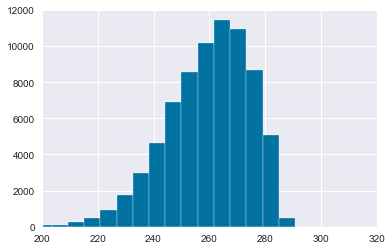

In [717]:
plt.hist(feature_df['Proj_Points'], bins=50)
plt.xlim(200, 320)
plt.show()

# Made/Missed Payout Classification

In [718]:
classification_df = feature_df.loc[:, :'Made_Payout'].drop(columns=['Total_Salary', 'slate_info'])
classification_df

,Proj_Points,Total_Own,Total_Leverage,slate_size,Made_Payout
0,280.28,125.3,-26.7,8,1
1,266.50,104.4,-24.3,8,1
2,273.43,127.5,-38.5,8,1
3,274.78,103.0,-13.8,8,1
4,277.44,142.6,-40.3,8,1
...,...,...,...,...,...
73542,236.76,59.1,-8.6,8,0
73543,231.40,73.4,-19.3,8,0
73544,215.28,51.6,3.4,8,0
73545,162.67,37.7,2.6,8,0


In [719]:
# not scaled
X_noscale = classification_df.loc[:, :'slate_size']
y_noscale = classification_df['Made_Payout']

X_train, X_test, y_train, y_test = train_test_split(X_noscale, y_noscale, test_size=0.2, random_state=0)

In [720]:
# rfr baseline
from sklearn.ensemble import RandomForestClassifier

# regr = RandomForestRegressor(max_depth=2, random_state=0)
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [721]:
perm = PermutationImportance(rfc, random_state=0).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.1126 ± 0.0043,Total_Leverage
0.0776 ± 0.0048,Proj_Points
0.0622 ± 0.0028,Total_Own
0.0001 ± 0.0004,slate_size


In [722]:
y_pred = rfc.predict(X_test)
rf_acc = rfc.score(X_test, y_test)
rf_f1 = f1_score(y_test, y_pred)

print(f"Random Forest:\nAccuracy: {rf_acc}\nF1 Score: {rf_f1}\n")

Random Forest:
Accuracy: 0.8245411284840245
F1 Score: 0.5570619529775184



In [723]:
feature_names = X_train.columns.to_list()

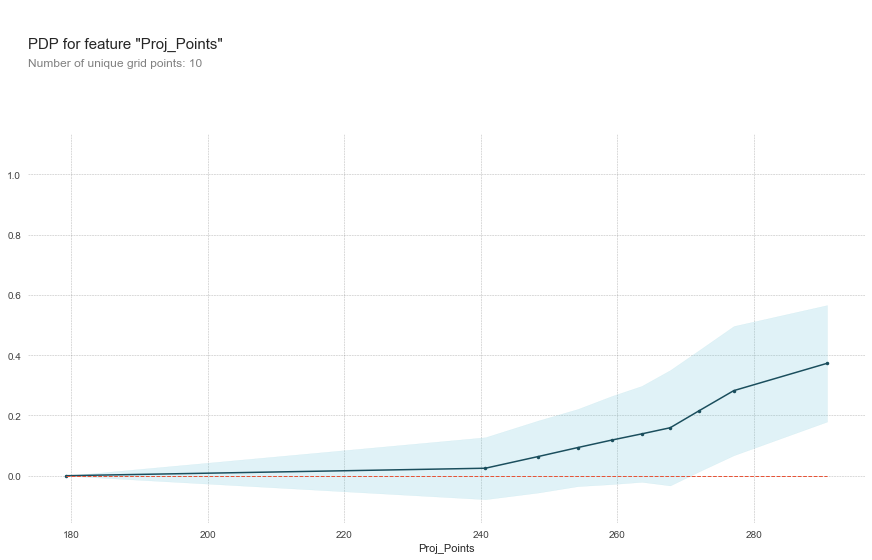

In [724]:
feature_to_plot = 'Proj_Points'
pdp_dist = pdp.pdp_isolate(model=rfc, dataset=X_test, model_features=feature_names, feature=feature_to_plot, num_grid_points=10)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

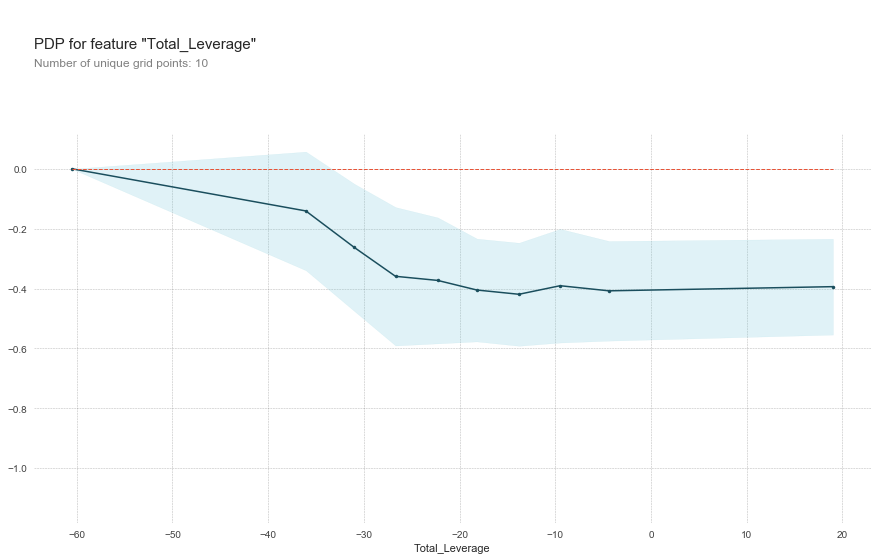

In [725]:
feature_to_plot = 'Total_Leverage'
pdp_dist = pdp.pdp_isolate(model=rfc, dataset=X_test, model_features=feature_names, feature=feature_to_plot, num_grid_points=10)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

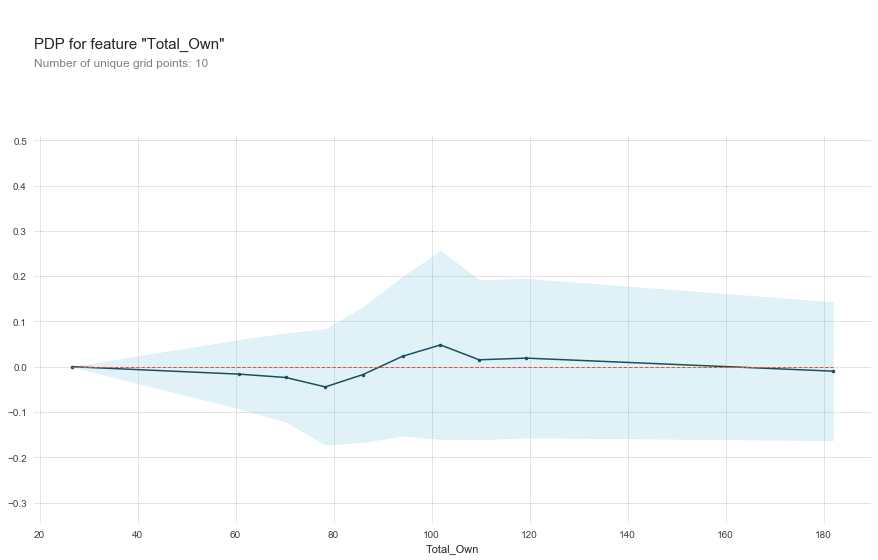

In [726]:
feature_to_plot = 'Total_Own'
pdp_dist = pdp.pdp_isolate(model=rfc, dataset=X_test, model_features=feature_names, feature=feature_to_plot, num_grid_points=10)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

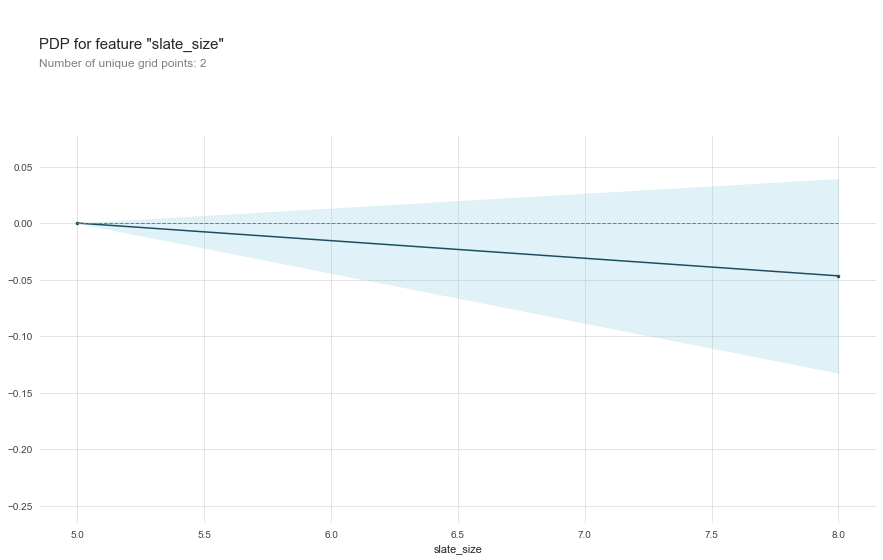

In [727]:
feature_to_plot = 'slate_size'
pdp_dist = pdp.pdp_isolate(model=rfc, dataset=X_test, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

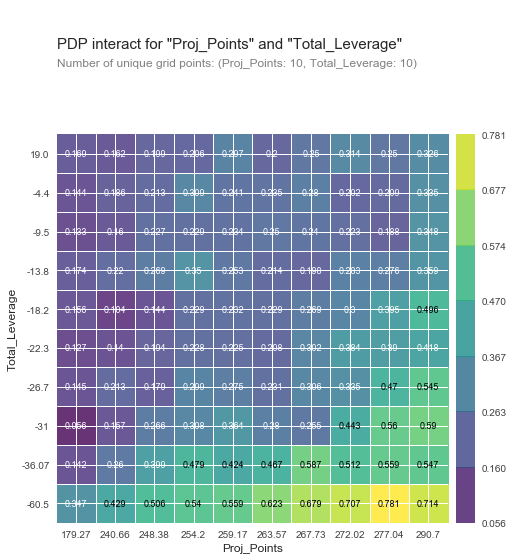

In [728]:
features_to_plot = ['Proj_Points', 'Total_Leverage']
inter1  =  pdp.pdp_interact(model=rfc, dataset=X_test, model_features=feature_names, features=features_to_plot)

# pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='grid')
plt.show()

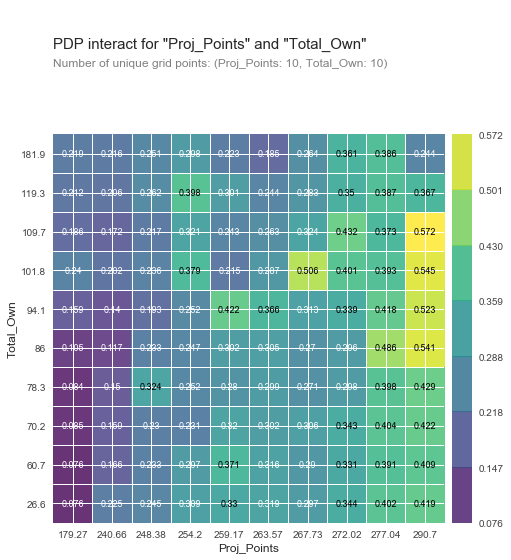

In [729]:
features_to_plot = ['Proj_Points', 'Total_Own']
inter1  =  pdp.pdp_interact(model=rfc, dataset=X_test, model_features=feature_names, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='grid')
plt.show()

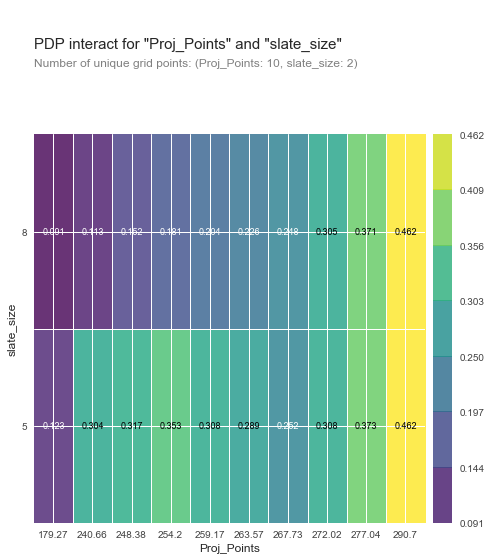

In [730]:
features_to_plot = ['Proj_Points', 'slate_size']
inter1  =  pdp.pdp_interact(model=rfc, dataset=X_test, model_features=feature_names, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='grid')
plt.show()

In [731]:
Xnoscale_df = pd.DataFrame(X_noscale, columns=['Proj_Points', 'Total_Own', 'Total_Leverage', 'slate_size'])
Xnoscale_df['payout_preds'] = rfc.predict(Xnoscale_df)
Xnoscale_df

,Proj_Points,Total_Own,Total_Leverage,slate_size,payout_preds
0,280.28,125.3,-26.7,8,1
1,266.50,104.4,-24.3,8,1
2,273.43,127.5,-38.5,8,1
3,274.78,103.0,-13.8,8,0
4,277.44,142.6,-40.3,8,1
...,...,...,...,...,...
73542,236.76,59.1,-8.6,8,0
73543,231.40,73.4,-19.3,8,0
73544,215.28,51.6,3.4,8,0
73545,162.67,37.7,2.6,8,0


In [732]:
# calculating the percentage of the field predicted to make payout. in most contests, it's about 25%
Xnoscale_df['payout_preds'].sum() / len(Xnoscale_df['payout_preds'])

0.22983942241015948

In [733]:
# explaining the first lineup's probabilty of just making payout
eli5.explain_prediction(rfc, Xnoscale_df.iloc[0, :-1])

Explanation(estimator='RandomForestClassifier()', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble (or a single tree for DecisionTreeClassifier).\nEach node of the tree has an output score, and contribution of a feature\non the decision path is how much the score changes from parent to child.\nWeights of all features sum to the output score or proba of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision path', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='Proj_Points', weight=0.35747996682152283, std=None, value=280.28), FeatureWeight(feature='Total_Own', weight=0.3554921711170421, std=None, value=125.30000000000001), FeatureWeight(feature='<BIAS>', weight=0.24883440692081515, std=None, value=1.0), FeatureWeight(feature='slate_size', weight=0.0004147072695248083, std=None, value=8.0)], neg=[FeatureWeight(feature='Total_Leverage', weight=-0.11222125212890538, std=None, value=-26.700000000000003)], pos_remaining=0, neg_remaining=0), proba=0.85, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

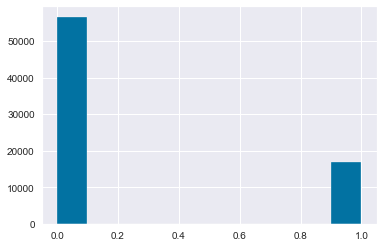

In [734]:
plt.hist(Xnoscale_df['payout_preds'])
plt.show()

In [735]:
X_original = classification_df.loc[:, :'slate_size']
X_original.head(3)

,Proj_Points,Total_Own,Total_Leverage,slate_size
0,280.28,125.3,-26.7,8
1,266.50,104.4,-24.3,8
2,273.43,127.5,-38.5,8


In [736]:
test_preds = pd.concat([X_original, Xnoscale_df['payout_preds']], axis=1)
test_preds.head(3)

,Proj_Points,Total_Own,Total_Leverage,slate_size,payout_preds
0,280.28,125.3,-26.7,8,1
1,266.50,104.4,-24.3,8,1
2,273.43,127.5,-38.5,8,1


In [737]:
test_preds.groupby('payout_preds').describe()

Proj_Points                                                  \
                   count        mean        std    min       25%     50%   
payout_preds                                                               
0                56643.0  256.909081  15.125154    0.0  247.6700  258.57   
1                16904.0  268.499245  11.499471  200.5  262.0475  270.86   

                            Total_Own                                     \
                 75%    max     count        mean        std   min   25%   
payout_preds                                                               
0             267.89  290.7   56643.0   86.178227  22.624100   0.0  69.2   
1             277.10  289.6   16904.0  104.754058  19.918716  32.3  92.1   

                                  Total_Leverage                              \
                50%    75%    max          count       mean        std   min   
payout_preds                                                                   
0              85.1  102.4  181.9        56643.0 -17.911668  11.721294 -60.1   
1             106.9  119.3  176.1        16904.0 -28.070758  11.773851 -60.5   

                                       slate_size                           \
               25%   50%     75%   max      count      mean       std  min   
payout_preds                                                                 
0            -26.8 -17.8  -9.000  23.4    56643.0  7.904401  0.526936  5.0   
1            -37.1 -30.4 -19.975  20.6    16904.0  7.899550  0.539700  5.0   

                                  
              25%  50%  75%  max  
payout_preds                      
0             8.0  8.0  8.0  8.0  
1             8.0  8.0  8.0  8.0

In [738]:
make_payout_df = test_preds[test_preds['payout_preds']==1]
make_payout_df

,Proj_Points,Total_Own,Total_Leverage,slate_size,payout_preds
0,280.28,125.3,-26.7,8,1
1,266.50,104.4,-24.3,8,1
2,273.43,127.5,-38.5,8,1
4,277.44,142.6,-40.3,8,1
5,258.39,108.3,-33.2,8,1
...,...,...,...,...,...
71894,270.85,107.0,-33.1,8,1
72329,270.90,97.8,-23.1,8,1
72767,262.76,79.7,-16.2,8,1
72901,279.34,110.0,-29.2,8,1


Classification here had two purposes.

The first purpose was to set a constraint in solver that will have all line-ups expected to reach payout. A basic constraint is projected_points > 275, leverage < -50. Want to avoid too many solver constraints, so even just points > 275 might be good. I say 275 and not 270 because I do not plan on playing 2 game slates.

The second purpose was to set up another model that models only the data projected to reach payout.

# Feature Transformations

41 minutes in: https://www.youtube.com/watch?v=zwYHloLXH0c

In [739]:
with_payouts_df = make_payout_df.join(feature_df[['ROI', 'linear_ROI']])
with_payouts_df

,Proj_Points,Total_Own,Total_Leverage,slate_size,payout_preds,ROI,linear_ROI
0,280.28,125.3,-26.7,8,1,187400.0,670.119369
1,266.50,104.4,-24.3,8,1,74900.0,669.971069
2,273.43,127.5,-38.5,8,1,49900.0,669.822769
4,277.44,142.6,-40.3,8,1,31150.0,669.526170
5,258.39,108.3,-33.2,8,1,24900.0,669.377871
...,...,...,...,...,...,...,...
71894,270.85,107.0,-33.1,8,1,-100.0,-100.000000
72329,270.90,97.8,-23.1,8,1,-100.0,-100.000000
72767,262.76,79.7,-16.2,8,1,-100.0,-100.000000
72901,279.34,110.0,-29.2,8,1,-100.0,-100.000000


In [740]:
feature_df = with_payouts_df.copy()

In [741]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16904 entries, 0 to 73104
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Proj_Points     16904 non-null  float64
 1   Total_Own       16904 non-null  float64
 2   Total_Leverage  16904 non-null  float64
 3   slate_size      16904 non-null  int64  
 4   payout_preds    16904 non-null  int64  
 5   ROI             16904 non-null  float64
 6   linear_ROI      16904 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 1.5 MB


In [742]:
model_features_df = feature_df.loc[:, "Proj_Points":"slate_size"]
model_features_df.head(3)

,Proj_Points,Total_Own,Total_Leverage,slate_size
0,280.28,125.3,-26.7,8
1,266.50,104.4,-24.3,8
2,273.43,127.5,-38.5,8


In [743]:
data2 = model_features_df.copy()

In [744]:
skew_df = pd.DataFrame(data2.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data2[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,Proj_Points,-0.984909,0.984909,True
1,Total_Own,-0.342340,0.342340,False
2,Total_Leverage,0.566674,0.566674,True
3,slate_size,-5.186556,5.186556,True


In [745]:
data2.describe()

,Proj_Points,Total_Own,Total_Leverage,slate_size
count,16904.000000,16904.000000,16904.000000,16904.00000
mean,268.499245,104.754058,-28.070758,7.89955
std,11.499471,19.918716,11.773851,0.53970
min,200.500000,32.300000,-60.500000,5.00000
25%,262.047500,92.100000,-37.100000,8.00000
50%,270.860000,106.900000,-30.400000,8.00000
75%,277.100000,119.300000,-19.975000,8.00000
max,289.600000,176.100000,20.600000,8.00000


In [746]:
# best practice to transform skewed features, but i'm choosing not to for understandability and usability
# for column in skew_df.query("Skewed == True")['Feature'].values:
# #     data2[column] = np.log1p(data2[column])
#     data2[column] = np.log(data2[column])

In [747]:
skew_df = pd.DataFrame(data2.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data2[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,Proj_Points,-0.984909,0.984909,True
1,Total_Own,-0.342340,0.342340,False
2,Total_Leverage,0.566674,0.566674,True
3,slate_size,-5.186556,5.186556,True


In [748]:
data4 = data2.copy()

# Scaling

In [749]:
# # standard scaling everything
# scaler = StandardScaler()
# scaler.fit(data4)

# data4 = pd.DataFrame(scaler.transform(data4), index=data4.index, columns=data4.columns)

In [750]:
data4

,Proj_Points,Total_Own,Total_Leverage,slate_size
0,280.28,125.3,-26.7,8
1,266.50,104.4,-24.3,8
2,273.43,127.5,-38.5,8
4,277.44,142.6,-40.3,8
5,258.39,108.3,-33.2,8
...,...,...,...,...
71894,270.85,107.0,-33.1,8
72329,270.90,97.8,-23.1,8
72767,262.76,79.7,-16.2,8
72901,279.34,110.0,-29.2,8


In [751]:
data5 = data4.copy()

# Target Transformation

In [752]:
target = feature_df['linear_ROI']
# target = feature_df['ROI']
target

0        670.119369
1        669.971069
2        669.822769
4        669.526170
5        669.377871
            ...    
71894   -100.000000
72329   -100.000000
72767   -100.000000
72901   -100.000000
73104   -100.000000
Name: linear_ROI, Length: 16904, dtype: float64

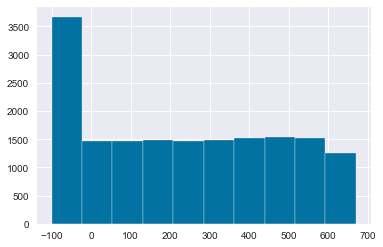

In [753]:
target.hist()

# Split Data

In [754]:
# X_train, X_test, y_train, y_test = train_test_split(data5, log_target_p100, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(data5, target, test_size=0.2, random_state=0)

# Model Selection

In [755]:
# _ = setup(data=pd.concat([X_train, y_train], axis=1), target='linear_ROI')

In [756]:
# compare_models()

# Baseline Model

In [757]:
# rfr baseline
from sklearn.ensemble import RandomForestRegressor

# regr = RandomForestRegressor(max_depth=2, random_state=0)
regr = RandomForestRegressor()
regr.fit(X_train, y_train)

RandomForestRegressor()

In [758]:
perm = PermutationImportance(regr, random_state=0).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.3872 ± 0.0156,Total_Leverage
0.2507 ± 0.0055,Proj_Points
0.2132 ± 0.0233,Total_Own
0.0002 ± 0.0001,slate_size


In [759]:
regr.score(X_test, y_test)

0.235542380559288

In [760]:
feature_names = X_test.columns

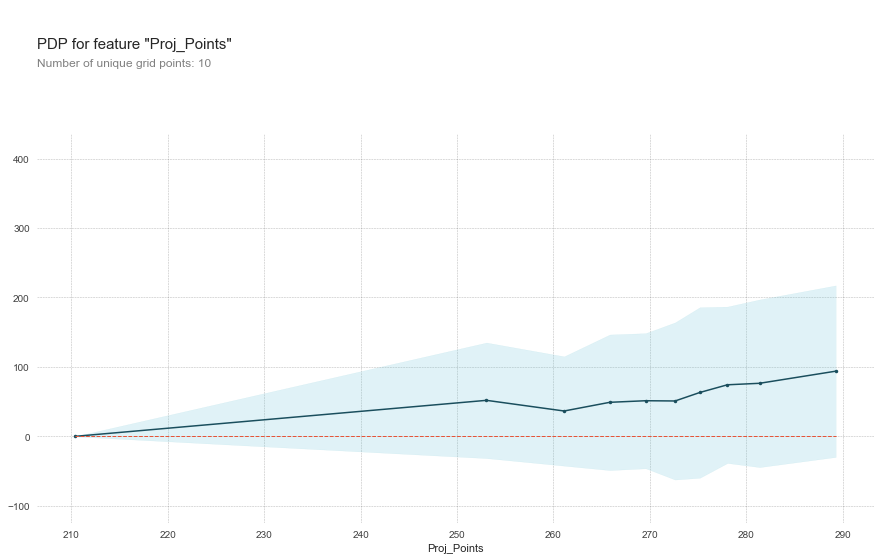

In [761]:
feature_to_plot = 'Proj_Points'
pdp_dist = pdp.pdp_isolate(model=regr, dataset=X_test, model_features=feature_names, feature=feature_to_plot, num_grid_points=10)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

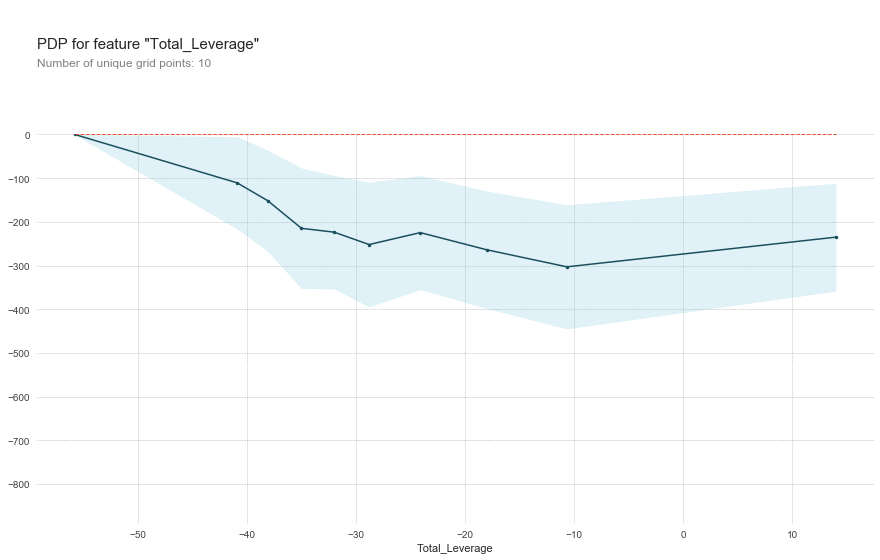

In [762]:
feature_to_plot = 'Total_Leverage'
pdp_dist = pdp.pdp_isolate(model=regr, dataset=X_test, model_features=feature_names, feature=feature_to_plot, num_grid_points=10)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

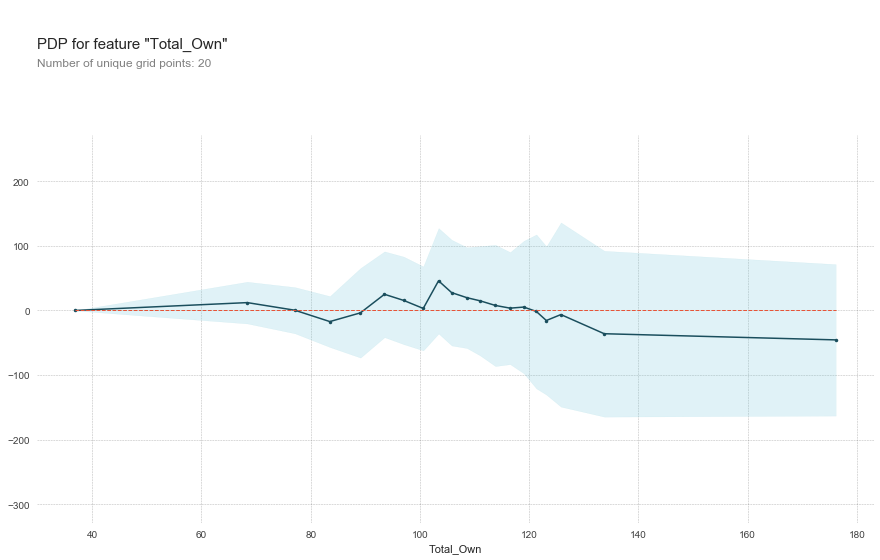

In [763]:
feature_to_plot = 'Total_Own'
pdp_dist = pdp.pdp_isolate(model=regr, dataset=X_test, model_features=feature_names, feature=feature_to_plot, num_grid_points=20)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

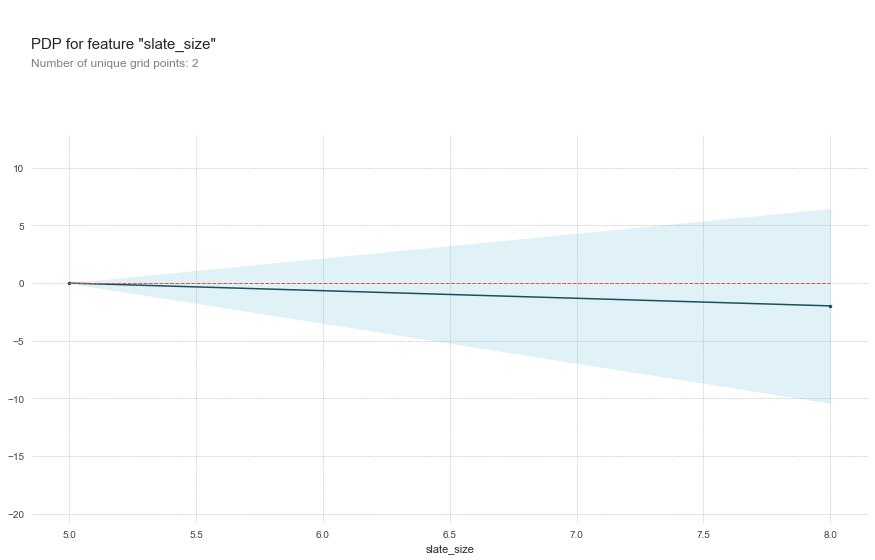

In [764]:
feature_to_plot = 'slate_size'
pdp_dist = pdp.pdp_isolate(model=regr, dataset=X_test, model_features=feature_names, feature=feature_to_plot, num_grid_points=20)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

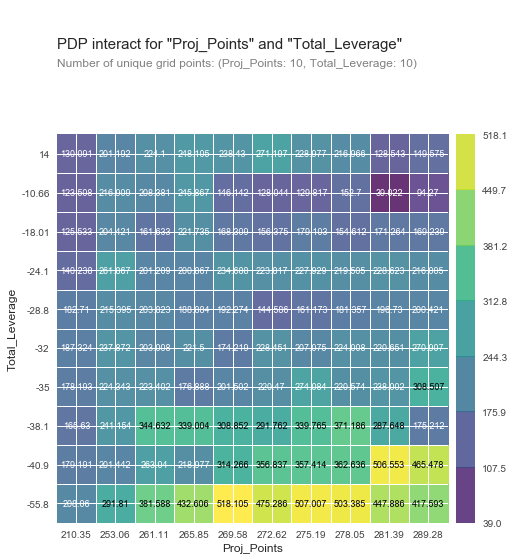

In [765]:
features_to_plot = ['Proj_Points', 'Total_Leverage']
inter1  =  pdp.pdp_interact(model=regr, dataset=X_test, model_features=feature_names, features=features_to_plot)

# pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='grid')
plt.show()

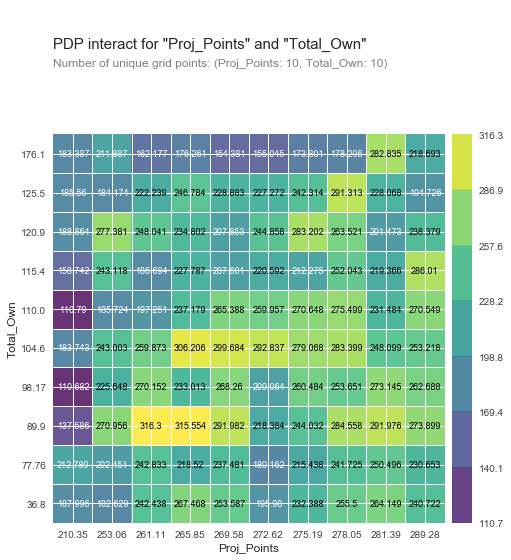

In [766]:
features_to_plot = ['Proj_Points', 'Total_Own']
inter1  =  pdp.pdp_interact(model=regr, dataset=X_test, model_features=feature_names, features=features_to_plot)

# pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='grid')
plt.show()

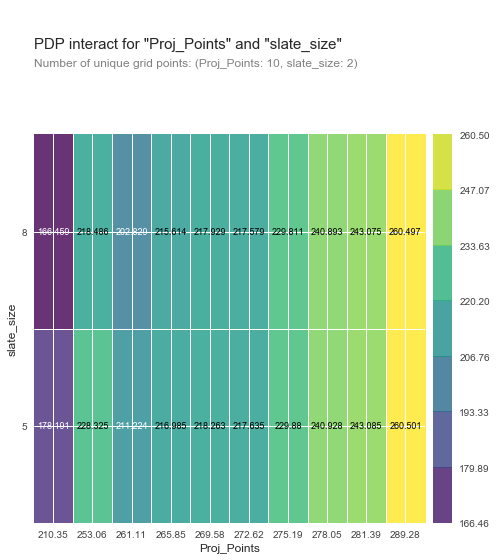

In [767]:
features_to_plot = ['Proj_Points', 'slate_size']
inter1  =  pdp.pdp_interact(model=regr, dataset=X_test, model_features=feature_names, features=features_to_plot)

# pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='grid')
plt.show()

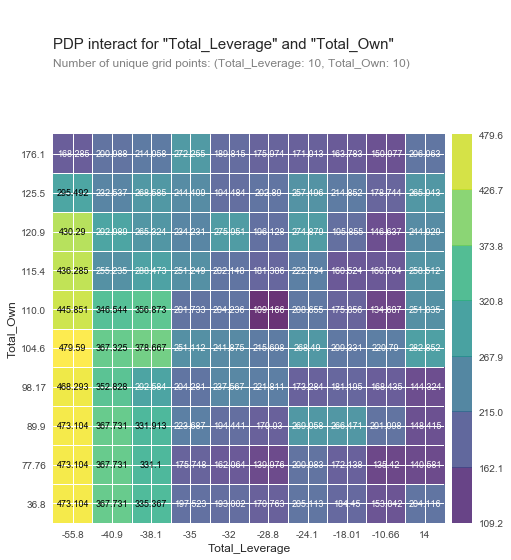

In [768]:
features_to_plot = ['Total_Leverage', 'Total_Own']
inter1  =  pdp.pdp_interact(model=regr, dataset=X_test, model_features=feature_names, features=features_to_plot)

# pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='grid')
plt.show()

In [769]:
source = 'C:/Users/mattd/OneDrive/Documents/ff/NBA/2022/contests/unprocessed'
  
# Destination path
destination = 'C:/Users/mattd/OneDrive/Documents/ff/NBA/2022/contests/processed'
  
# Move the content of
# source to destination
for dir in dir_list:
    dest = shutil.move(f'{source}/{dir}', destination)